<a href="https://colab.research.google.com/github/jairsilva0742/SignLanguageDetector/blob/main/01_Entrenamiento_Obtencion_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto de Detección de Letras - Lenguaje de Señas**
### **Integrantes**

*   Jair Silva Herrera - C.C. 1.030.375.674
*   Leonardo Castro Piracoa - C.C. 1.073.688.809


**Parte 1. Obtención de DataSet**

---


*El Data set usado corresponde a una serie de imagenes de cada una de las letras del abecedario inglés en Lenguaje de Señas. El Dataset ya esta dividido en carpetas para entrenamiento (Train), y prueba (Test). Por cada letra hay 5996 imágenes en la carpeta de entrenamiento, mientras que hay 4 imágenes en la carpeta de prueba. Las imágenes tienen un tamaño de 400 * 400 pixeles.*


In [ ]:
#Se hace instalación de paquete de kaggle
!pip install -q kaggle

In [ ]:
# Se usa la extensión de google colab para subir el token descargado de Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jairsilvaherrera","key":"a3c874a9e3993c192a3eead9dd17d069"}'}

In [ ]:
#Se crea directorio
!mkdir ~/.kaggle

In [ ]:
#Se copia archivo en carpeta de colab
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Se carga el dataset desde kaggle en formato comprimido
!kaggle datasets download -d kapillondhe/american-sign-language

Dataset URL: https://www.kaggle.com/datasets/kapillondhe/american-sign-language
License(s): GPL-2.0
100% 4.62G/4.64G [01:09<00:00, 119MB/s]
100% 4.64G/4.64G [01:10<00:00, 71.1MB/s]


In [ ]:
#Se descomprimen los archivos
!unzip american-sign-language.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: ASL_Dataset/Train/Z/1897.jpg  
  inflating: ASL_Dataset/Train/Z/1898.jpg  
  inflating: ASL_Dataset/Train/Z/1899.jpg  
  inflating: ASL_Dataset/Train/Z/19.jpg  
  inflating: ASL_Dataset/Train/Z/190.jpg  
  inflating: ASL_Dataset/Train/Z/1900.jpg  
  inflating: ASL_Dataset/Train/Z/1901.jpg  
  inflating: ASL_Dataset/Train/Z/1902.jpg  
  inflating: ASL_Dataset/Train/Z/1903.jpg  
  inflating: ASL_Dataset/Train/Z/1904.jpg  
  inflating: ASL_Dataset/Train/Z/1905.jpg  
  inflating: ASL_Dataset/Train/Z/1906.jpg  
  inflating: ASL_Dataset/Train/Z/1907.jpg  
  inflating: ASL_Dataset/Train/Z/1908.jpg  
  inflating: ASL_Dataset/Train/Z/1909.jpg  
  inflating: ASL_Dataset/Train/Z/191.jpg  
  inflating: ASL_Dataset/Train/Z/1910.jpg  
  inflating: ASL_Dataset/Train/Z/1911.jpg  
  inflating: ASL_Dataset/Train/Z/1912.jpg  
  inflating: ASL_Dataset/Train/Z/1913.jpg  
  inflating: ASL_Dataset/Train/Z/1914.jpg  
  inflating: ASL_Da

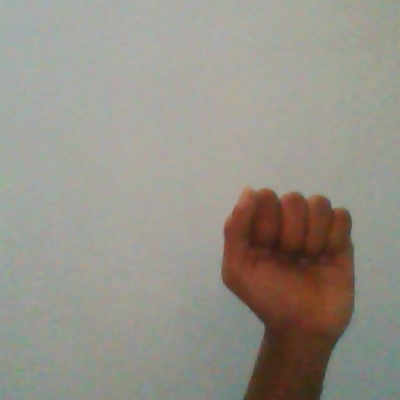

In [ ]:
from IPython.display import Image
Image(filename='ASL_Dataset/Train/A/1066.jpg', width=500)

**Parte 2. Pre Procesamiento de Datos**

---

*Antes de usar las imágenes, se hace un pre procesamiento con el fin de obtener mejores resultados y funcione más adecuadamente. En primera instancia se reescalan los valores de RGB que van de 0 a 255, para pasarlos de 0 a 1; además de transformar algunas imágenes para que salgan en el lado opuesto (efecto espejo), cubriendo la posibilidad de que se usen la mano izquierda o derecha. Por otro lado se aplican otros efectos para cubrir las posibles inclinaciones de las manos y el acercamiento o alejamiento de estas. Finalmente, se hace un ajuste en el tamaño de las imágenes, volviéndolas de 150 x 150 pixeles.*

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import numpy as np

In [ ]:
#Pre procesado de imagenes
setEntrenamiento = ImageDataGenerator(rescale = 1./255,
                                      horizontal_flip = True,
                                      shear_range=0.3,
                                      zoom_range = 0.3)
setPrueba = ImageDataGenerator(rescale = 1./255)
Data_Entrenamiento = setEntrenamiento.flow_from_directory('ASL_Dataset/Train/',
                                        target_size = (150, 150),
                                        batch_size = 32,
                                        class_mode = 'categorical'
                                        )


Data_Prueba = setPrueba.flow_from_directory('ASL_Dataset/Test/',
                                    target_size = (150, 150),
                                    batch_size = 32,
                                    class_mode = 'categorical',                                    )

if Data_Entrenamiento.class_indices == Data_Prueba.class_indices:
    print(Data_Entrenamiento.class_indices)

Found 165670 images belonging to 28 classes.
Found 112 images belonging to 28 classes.
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'Nothing': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'Space': 20, 'T': 21, 'U': 22, 'V': 23, 'W': 24, 'X': 25, 'Y': 26, 'Z': 27}


**Parte 3. Modelo de Redes Convolucionales**

---
*En esta parte se desarrolla la red convolucional del modelo. Para el desarrollo de esta se usa el Dropout para evitar el sobre ajuste mediante desactivación de una parte de las neuronas, y el Maxpooling que genera los datos mas altos de una región como dato para la siguiente capa.
Para encontrar el modelo más adecuado, se corre el modelo con algunas variaciones: se van a variar el numero de capas y el numero de Filtros.
Se va a correr el modelo con 1,2 y 3 capas convolucionales y se van a variar la cantidad de filtros en los 3 casos, con el fin de definir cual es la opción que mas se ajusta.*

In [ ]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
!pip install mlutils



  Preparing metadata (setup.py) ... done
  Created wheel for mlutils: filename=mlutils-0.2.0b0-py3-none-any.whl size=12060 sha256=c73c4d61bd5b6a6f04d846a6ca1e6c465cc80dc3f2cc171183444c95604d127c
  Stored in directory: /root/.cache/pip/wheels/b4/a2/ee/e67a5e7ac520e31532ded497a13bd9961174ea761ec8a299dc
Successfully built mlutils


In [ ]:
def conv_modelo(num_classes, img_size=150, num_capas=1,multip=1):
    #Esta linea de código se usa para borrar datos de corridas anteriores que puedan afectar cada caso
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")

    #Acá se coloca la capa inicial la cual esta por defecto
    # el algoritmo pide datos de numero de capas y multiplicadores, los cuales sirven para que el programa identifique
    #si hay dos capas, o los filtros se dividen en 2, en cada una de las capas.

    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(32*multip,(7,7), activation="relu")(inputs)
    #pintar las 32 imegenes de los filtros_POR HACER
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)

    #Cuando el numero de capas son dos, se agrega una mas
    if num_capas==2:
      layers = tf.keras.layers.Conv2D(64*multip,(5,5), activation="relu")(layers)
      layers = tf.keras.layers.MaxPool2D((2,2))(layers)

    #Cuando el numero de capas son tres, se agregan dos mas
    if num_capas==3:
      layers = tf.keras.layers.Conv2D(64*multip,(5,5), activation="relu")(layers)
      layers = tf.keras.layers.MaxPool2D((2,2))(layers)
      layers = tf.keras.layers.Conv2D(128*multip,(3,3), activation="relu")(layers)
      layers = tf.keras.layers.Dropout(0.3)(layers)
      layers = tf.keras.layers.MaxPool2D((2,2))(layers)

    # aca se pone la capa Flatten que hace el ajuste a una dimensión, y las respectivas capas densas
    #la salida esta definida por el numero de clases
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(512*multip, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.3)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
#Se realiza una función para imprimir las imagenes de los filtros
def print_filtros(filtros):
  n_filters =10
  ix=1
  fig = plt.figure(figsize=(20,15))
  for i in range(n_filters):
    f = filtros[:,:,:,i]
    for j in range(3):
          # se grafican 6 filtros
          plt.subplot(n_filters,3,ix)
          plt.imshow(f[:,:,j])
          ix+=1

  plt.axis('off')
  plt.show()
  return

**Parte 3.1. Obtención de Modelos**

---
*En esta sección se obtienen los 6 modelos a entrenar, teniendo en cuenta las variaciones previamente descritas (1 a 3 capas / variación de cantidad de Filtros por capa).
Adicionalmente, se obtienen los filtros por capa*


In [ ]:
num_classes=len(Data_Prueba.class_indices)
model = conv_modelo(num_classes)
model.summary()
print(model.get_weights()[0].shape)
InicialW0_Model=model.get_weights()[0]

using 28 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 144, 144, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 165888)            0         
                                                                 
 dense (Dense)               (None, 512)               84935168  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                            

In [ ]:
model1 = conv_modelo(num_classes,multip=0.5)
model1.summary()
InicialW0_Model1=model1.get_weights()[0]

using 28 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 144, 144, 16)      2368      
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 256)               21233920  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                            

In [ ]:
model2 = conv_modelo(num_classes,num_capas=2)
model2.summary()
print(model2.get_weights()[2].shape)
InicialW0_Model2=model2.get_weights()[2]

using 28 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 144, 144, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 68, 68, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 73984)  

In [ ]:
model3 = conv_modelo(num_classes,num_capas=2,multip=0.5)
model3.summary()
print(model3.get_weights()[2].shape)
InicialW0_Model3=model3.get_weights()[2]

using 28 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 144, 144, 16)      2368      
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 68, 68, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 36992)  

In [ ]:
model4 = conv_modelo(num_classes,num_capas=3)
model4.summary()
print(model4.get_weights()[4].shape)
InicialW0_Model4=model4.get_weights()[4]

using 28 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 144, 144, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 68, 68, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 

In [ ]:
model5 = conv_modelo(num_classes,num_capas=3,multip=0.5)
model5.summary()
print(model5.get_weights()[4].shape)
InicialW0_Model5=model5.get_weights()[4]

using 28 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 144, 144, 16)      2368      
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 68, 68, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 

**Parte 3.2. Entrenamiento de Modelos**

---
*En esta sección se entrenan los 6 modelos, bajo las mismas condiciones para evitar ruido: 25 épocas, pasos por epoca 32, tamaño de batch 32.*


In [ ]:
model.fit(Data_Entrenamiento,
          batch_size = 32,
          steps_per_epoch = 32,
          epochs = 25,
          validation_data = Data_Prueba,
          validation_steps = 2,
          verbose = 2)


Epoch 1/25
32/32 - 32s - loss: 4.6128 - accuracy: 0.0391 - val_loss: 3.3328 - val_accuracy: 0.0156 - 32s/epoch - 1s/step
Epoch 2/25
32/32 - 9s - loss: 3.3324 - accuracy: 0.0361 - val_loss: 3.3331 - val_accuracy: 0.0469 - 9s/epoch - 267ms/step
Epoch 3/25
32/32 - 9s - loss: 3.3327 - accuracy: 0.0371 - val_loss: 3.3323 - val_accuracy: 0.0469 - 9s/epoch - 281ms/step
Epoch 4/25
32/32 - 10s - loss: 3.3320 - accuracy: 0.0410 - val_loss: 3.3349 - val_accuracy: 0.0312 - 10s/epoch - 301ms/step
Epoch 5/25
32/32 - 8s - loss: 3.3322 - accuracy: 0.0322 - val_loss: 3.3337 - val_accuracy: 0.0625 - 8s/epoch - 240ms/step
Epoch 6/25
32/32 - 9s - loss: 3.3318 - accuracy: 0.0371 - val_loss: 3.3343 - val_accuracy: 0.0312 - 9s/epoch - 293ms/step
Epoch 7/25
32/32 - 9s - loss: 3.3316 - accuracy: 0.0361 - val_loss: 3.3359 - val_accuracy: 0.0312 - 9s/epoch - 296ms/step
Epoch 8/25
32/32 - 10s - loss: 3.3325 - accuracy: 0.0303 - val_loss: 3.3348 - val_accuracy: 0.0312 - 10s/epoch - 315ms/step
Epoch 9/25
32/32 - 9s

In [ ]:
model1.fit(Data_Entrenamiento,
          batch_size = 32,
          steps_per_epoch = 32,
          epochs = 25,
          validation_data = Data_Prueba,
          validation_steps = 2,
          verbose = 2)

Epoch 1/25
32/32 - 12s - loss: 4.2287 - accuracy: 0.0361 - val_loss: 3.3326 - val_accuracy: 0.0312 - 12s/epoch - 374ms/step
Epoch 2/25
32/32 - 10s - loss: 3.3322 - accuracy: 0.0459 - val_loss: 3.3322 - val_accuracy: 0.0469 - 10s/epoch - 321ms/step
Epoch 3/25
32/32 - 7s - loss: 3.3311 - accuracy: 0.0352 - val_loss: 3.3320 - val_accuracy: 0.0312 - 7s/epoch - 221ms/step
Epoch 4/25
32/32 - 11s - loss: 3.2899 - accuracy: 0.0410 - val_loss: 3.2273 - val_accuracy: 0.0469 - 11s/epoch - 337ms/step
Epoch 5/25
32/32 - 8s - loss: 3.2102 - accuracy: 0.0703 - val_loss: 3.1115 - val_accuracy: 0.1406 - 8s/epoch - 264ms/step
Epoch 6/25
32/32 - 8s - loss: 3.1483 - accuracy: 0.1055 - val_loss: 2.9695 - val_accuracy: 0.2188 - 8s/epoch - 245ms/step
Epoch 7/25
32/32 - 12s - loss: 3.0541 - accuracy: 0.1191 - val_loss: 2.8324 - val_accuracy: 0.3125 - 12s/epoch - 366ms/step
Epoch 8/25
32/32 - 14s - loss: 2.9323 - accuracy: 0.1611 - val_loss: 2.6580 - val_accuracy: 0.2344 - 14s/epoch - 434ms/step
Epoch 9/25
32/

In [ ]:
model2.fit(Data_Entrenamiento,
          batch_size = 32,
          steps_per_epoch = 32,
          epochs = 25,
          validation_data = Data_Prueba,
          validation_steps = 2,
          verbose = 2)

Epoch 1/25
32/32 - 11s - loss: 3.7839 - accuracy: 0.0430 - val_loss: 3.3131 - val_accuracy: 0.0781 - 11s/epoch - 344ms/step
Epoch 2/25
32/32 - 9s - loss: 3.1699 - accuracy: 0.1064 - val_loss: 2.7428 - val_accuracy: 0.2344 - 9s/epoch - 278ms/step
Epoch 3/25
32/32 - 12s - loss: 2.8131 - accuracy: 0.1865 - val_loss: 2.1052 - val_accuracy: 0.4375 - 12s/epoch - 387ms/step
Epoch 4/25
32/32 - 9s - loss: 2.5541 - accuracy: 0.2422 - val_loss: 1.9636 - val_accuracy: 0.5312 - 9s/epoch - 274ms/step
Epoch 5/25
32/32 - 8s - loss: 2.3953 - accuracy: 0.2891 - val_loss: 1.5115 - val_accuracy: 0.6094 - 8s/epoch - 259ms/step
Epoch 6/25
32/32 - 7s - loss: 2.2305 - accuracy: 0.3252 - val_loss: 1.4893 - val_accuracy: 0.6562 - 7s/epoch - 228ms/step
Epoch 7/25
32/32 - 9s - loss: 2.0807 - accuracy: 0.3750 - val_loss: 1.1910 - val_accuracy: 0.6719 - 9s/epoch - 286ms/step
Epoch 8/25
32/32 - 7s - loss: 1.8785 - accuracy: 0.4033 - val_loss: 1.2507 - val_accuracy: 0.7031 - 7s/epoch - 227ms/step
Epoch 9/25
32/32 - 8

In [ ]:
model3.fit(Data_Entrenamiento,
          batch_size = 32,
          steps_per_epoch = 32,
          epochs = 25,
          validation_data = Data_Prueba,
          validation_steps = 2,
          verbose = 2)

Epoch 1/25
32/32 - 10s - loss: 3.8198 - accuracy: 0.0410 - val_loss: 3.3315 - val_accuracy: 0.0312 - 10s/epoch - 326ms/step
Epoch 2/25
32/32 - 7s - loss: 3.3152 - accuracy: 0.0703 - val_loss: 3.2136 - val_accuracy: 0.1875 - 7s/epoch - 227ms/step
Epoch 3/25
32/32 - 9s - loss: 3.1783 - accuracy: 0.0859 - val_loss: 2.8052 - val_accuracy: 0.2188 - 9s/epoch - 270ms/step
Epoch 4/25
32/32 - 7s - loss: 2.9830 - accuracy: 0.1445 - val_loss: 2.4212 - val_accuracy: 0.5000 - 7s/epoch - 211ms/step
Epoch 5/25
32/32 - 7s - loss: 2.7552 - accuracy: 0.2285 - val_loss: 2.1253 - val_accuracy: 0.5156 - 7s/epoch - 211ms/step
Epoch 6/25
32/32 - 8s - loss: 2.7044 - accuracy: 0.2598 - val_loss: 2.0081 - val_accuracy: 0.6094 - 8s/epoch - 250ms/step
Epoch 7/25
32/32 - 9s - loss: 2.4179 - accuracy: 0.3252 - val_loss: 2.0240 - val_accuracy: 0.5156 - 9s/epoch - 270ms/step
Epoch 8/25
32/32 - 7s - loss: 2.2938 - accuracy: 0.3604 - val_loss: 1.9072 - val_accuracy: 0.3438 - 7s/epoch - 214ms/step
Epoch 9/25
32/32 - 11s

In [ ]:
model4.fit(Data_Entrenamiento,
          batch_size = 32,
          steps_per_epoch = 32,
          epochs = 25,
          validation_data = Data_Prueba,
          validation_steps = 2,
          verbose = 2)

Epoch 1/25
32/32 - 11s - loss: 3.4850 - accuracy: 0.0410 - val_loss: 3.3327 - val_accuracy: 0.0312 - 11s/epoch - 345ms/step
Epoch 2/25
32/32 - 9s - loss: 3.3284 - accuracy: 0.0518 - val_loss: 3.3210 - val_accuracy: 0.0469 - 9s/epoch - 278ms/step
Epoch 3/25
32/32 - 7s - loss: 3.3128 - accuracy: 0.0479 - val_loss: 3.2544 - val_accuracy: 0.1250 - 7s/epoch - 223ms/step
Epoch 4/25
32/32 - 9s - loss: 3.2343 - accuracy: 0.0781 - val_loss: 3.1376 - val_accuracy: 0.1875 - 9s/epoch - 278ms/step
Epoch 5/25
32/32 - 9s - loss: 3.0391 - accuracy: 0.1396 - val_loss: 2.6185 - val_accuracy: 0.2969 - 9s/epoch - 283ms/step
Epoch 6/25
32/32 - 7s - loss: 2.7115 - accuracy: 0.2002 - val_loss: 2.3045 - val_accuracy: 0.4219 - 7s/epoch - 227ms/step
Epoch 7/25
32/32 - 8s - loss: 2.3354 - accuracy: 0.2969 - val_loss: 1.8220 - val_accuracy: 0.5938 - 8s/epoch - 253ms/step
Epoch 8/25
32/32 - 9s - loss: 2.1643 - accuracy: 0.3564 - val_loss: 1.5813 - val_accuracy: 0.6250 - 9s/epoch - 283ms/step
Epoch 9/25
32/32 - 8s 

In [ ]:
model5.fit(Data_Entrenamiento,
          batch_size = 32,
          steps_per_epoch = 32,
          epochs = 25,
          validation_data = Data_Prueba,
          validation_steps = 2,
          verbose = 2)

Epoch 1/25
32/32 - 9s - loss: 3.3561 - accuracy: 0.0381 - val_loss: 3.3155 - val_accuracy: 0.1406 - 9s/epoch - 293ms/step
Epoch 2/25
32/32 - 8s - loss: 3.2390 - accuracy: 0.0781 - val_loss: 2.9829 - val_accuracy: 0.2031 - 8s/epoch - 244ms/step
Epoch 3/25
32/32 - 9s - loss: 2.9907 - accuracy: 0.1396 - val_loss: 2.7280 - val_accuracy: 0.2344 - 9s/epoch - 268ms/step
Epoch 4/25
32/32 - 7s - loss: 2.8637 - accuracy: 0.1826 - val_loss: 2.4499 - val_accuracy: 0.2969 - 7s/epoch - 217ms/step
Epoch 5/25
32/32 - 9s - loss: 2.5567 - accuracy: 0.2432 - val_loss: 2.0210 - val_accuracy: 0.4531 - 9s/epoch - 266ms/step
Epoch 6/25
32/32 - 7s - loss: 2.1728 - accuracy: 0.3535 - val_loss: 1.7361 - val_accuracy: 0.6719 - 7s/epoch - 212ms/step
Epoch 7/25
32/32 - 9s - loss: 2.0245 - accuracy: 0.3809 - val_loss: 1.5488 - val_accuracy: 0.6562 - 9s/epoch - 270ms/step
Epoch 8/25
32/32 - 9s - loss: 1.6718 - accuracy: 0.4678 - val_loss: 1.0975 - val_accuracy: 0.7656 - 9s/epoch - 267ms/step
Epoch 9/25
32/32 - 7s - 

In [ ]:
W0_Model=model.get_weights()[0]
W0_Model1=model1.get_weights()[0]
W0_Model2=model2.get_weights()[2]
W0_Model3=model3.get_weights()[2]
W0_Model4=model4.get_weights()[4]
W0_Model5=model5.get_weights()[4]

**Parte 3.4. Comparación de resultados**

---
*Medidante la comparación de la precisión por épocas obtenida en el entrenamiento, asi como la obtención de las matrices de confusión haciendo las predicciones con los datos de prueba, se elige el mejor modelo para utilizar posteriormente.
Como adicional se observa el comportamiento de los filtros de la ultima capa del modelo antes y después del almacenamiento.*


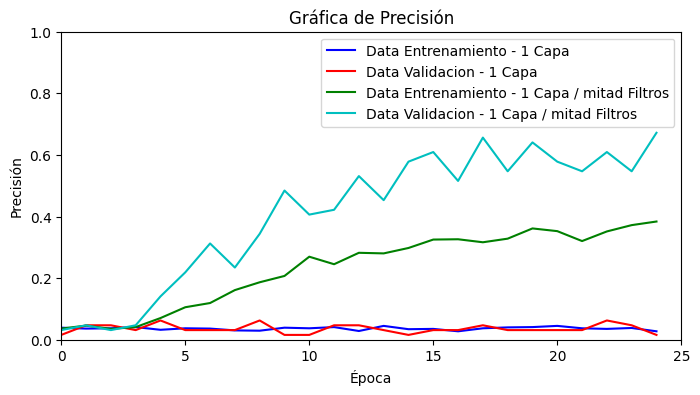

In [ ]:
# Se guardan los valores de precisión de los datos entrenados y los de prueba para comparar como evoluciona
#respecto a la época.
acc = model.history.history['accuracy']
valAcc = model.history.history['val_accuracy']
epoch = model.history.epoch
acc1 = model1.history.history['accuracy']
valAcc1 = model1.history.history['val_accuracy']
epoch1 = model1.history.epoch
acc2 = model2.history.history['accuracy']
valAcc2 = model2.history.history['val_accuracy']
epoch2 = model2.history.epoch
acc3 = model3.history.history['accuracy']
valAcc3 = model3.history.history['val_accuracy']
epoch3 = model3.history.epoch
acc4 = model4.history.history['accuracy']
valAcc4 = model4.history.history['val_accuracy']
epoch4 = model4.history.epoch
acc5 = model5.history.history['accuracy']
valAcc5 = model5.history.history['val_accuracy']
epoch5 = model5.history.epoch

#Primero de grafican los datos con una capa y variando cantidad de neuronas
plt.subplots(figsize=(8, 4))
plt.plot(epoch, acc, label = 'Data Entrenamiento - 1 Capa', color = 'b')
plt.plot(epoch, valAcc, label = 'Data Validacion - 1 Capa', color = 'r')
plt.plot(epoch1, acc1, label = 'Data Entrenamiento - 1 Capa / mitad Filtros', color = 'g')
plt.plot(epoch1, valAcc1, label = 'Data Validacion - 1 Capa / mitad Filtros', color = 'c')

plt.xlabel('Época')
plt.ylabel('Precisión')
plt.xlim([0, len(epoch)])
plt.ylim([0, 1])
plt.title('Gráfica de Precisión')
plt.legend()
plt.show()


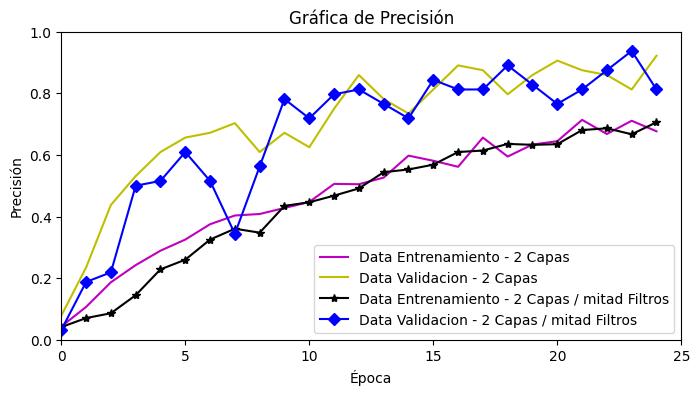

In [ ]:
#esta grafica corresponde a los datos con dos capas y variando cantidad de neuronas
plt.subplots(figsize=(8, 4))
plt.plot(epoch2, acc2, label = 'Data Entrenamiento - 2 Capas', color = 'm')
plt.plot(epoch2, valAcc2, label = 'Data Validacion - 2 Capas', color = 'y')
plt.plot(epoch3, acc3, label = 'Data Entrenamiento - 2 Capas / mitad Filtros', color = 'k', marker = '*')
plt.plot(epoch3, valAcc3, label = 'Data Validacion - 2 Capas / mitad Filtros', color = 'b', marker = 'D')

plt.xlabel('Época')
plt.ylabel('Precisión')
plt.xlim([0, len(epoch)])
plt.ylim([0, 1])
plt.title('Gráfica de Precisión')
plt.legend()
plt.show()

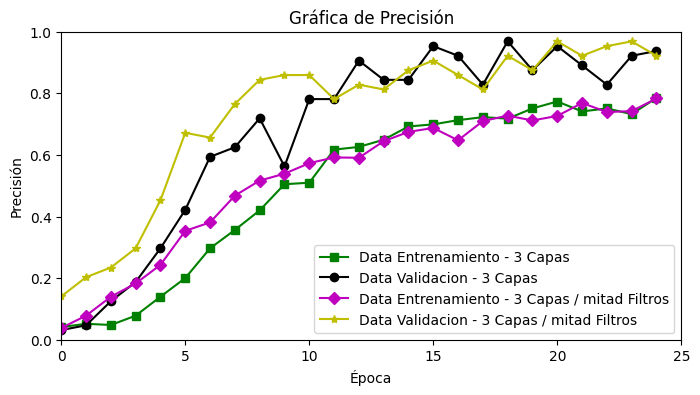

In [ ]:
#esta grafica corresponde a los datos con 3 capas y variando cantidad de neuronas
plt.subplots(figsize=(8, 4))
plt.plot(epoch4, acc4, label = 'Data Entrenamiento - 3 Capas', color = 'g', marker = 's')
plt.plot(epoch4, valAcc4, label = 'Data Validacion - 3 Capas', color = 'k', marker = 'o')
plt.plot(epoch5, acc5, label = 'Data Entrenamiento - 3 Capas / mitad Filtros', color = 'm', marker = 'D')
plt.plot(epoch5, valAcc5, label = 'Data Validacion - 3 Capas / mitad Filtros', color = 'y', marker = '*')


plt.xlabel('Época')
plt.ylabel('Precisión')
plt.xlim([0, len(epoch)])
plt.ylim([0, 1])
plt.title('Gráfica de Precisión')
plt.legend()
plt.show()

In [ ]:
!pip install Keras-Preprocessing
from keras_preprocessing import image
# se instala esta utilidad para leer las imagenes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
#Acá se obtienen las imagenes de la carpeta de prueba
import os
y_pred = []
y_pred1 = []
y_pred2 = []
y_pred3 = []
y_pred4 = []
y_pred5 = []
for i in Data_Prueba.class_indices:
    #Mediante un ciclo se recorren todos los archivos de la carpeta de prueba
    #el indice i corresponde a las clases que son las carpetas dentro de prueba (letras del abecedario)
    labelTest = 'ASL_Dataset/Test/'+i+'/'
    for j in os.listdir(labelTest):
        # Se guarda la dirección a evaluar
        x_pred = labelTest + j

        # Se carga imagen en un array
        img = image.load_img(x_pred, target_size = (150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis = 0)
        matxImg = np.vstack([x])

        #Se hace la respectiva predicción con cada uno de los modelos
        predict = model.predict(matxImg, batch_size = 32)
        predict = np.argmax(predict, axis = 1)
        y_pred.append(predict[0])
        predict1 = model1.predict(matxImg, batch_size = 32)
        predict1 = np.argmax(predict1, axis = 1)
        y_pred1.append(predict1[0])
        predict2 = model2.predict(matxImg, batch_size = 32)
        predict2 = np.argmax(predict2, axis = 1)
        y_pred2.append(predict2[0])
        predict3 = model3.predict(matxImg, batch_size = 32)
        predict3 = np.argmax(predict3, axis = 1)
        y_pred3.append(predict3[0])
        predict4 = model4.predict(matxImg, batch_size = 32)
        predict4 = np.argmax(predict4, axis = 1)
        y_pred4.append(predict4[0])
        predict5 = model5.predict(matxImg, batch_size = 32)
        predict5 = np.argmax(predict5, axis = 1)
        y_pred5.append(predict5[0])

1/1 [==============================] - 0s 196ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 17ms/step


Text(0.5, 1.0, 'Matriz Confusión - Modelo 3 Capas - Mitad Fil.')

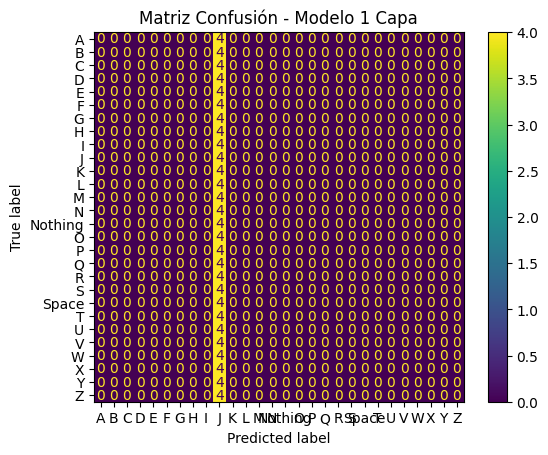

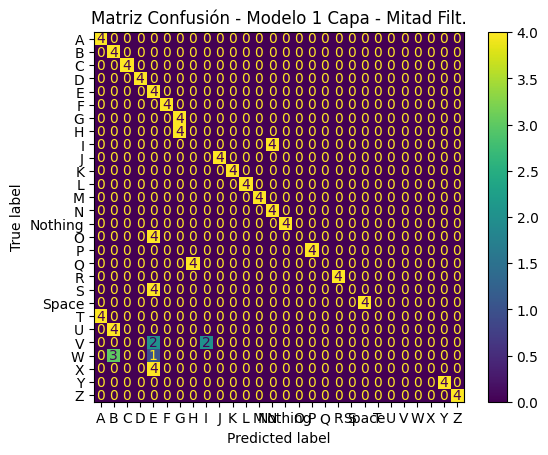

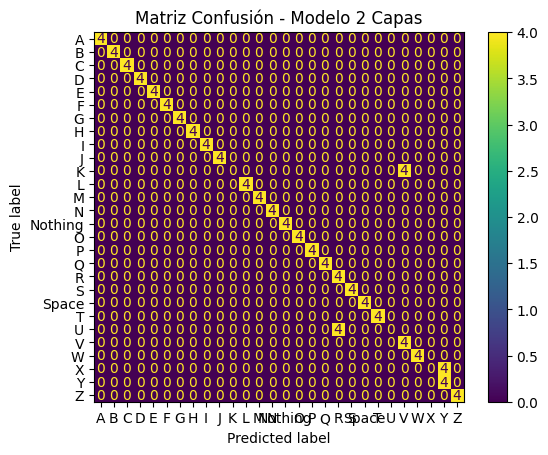

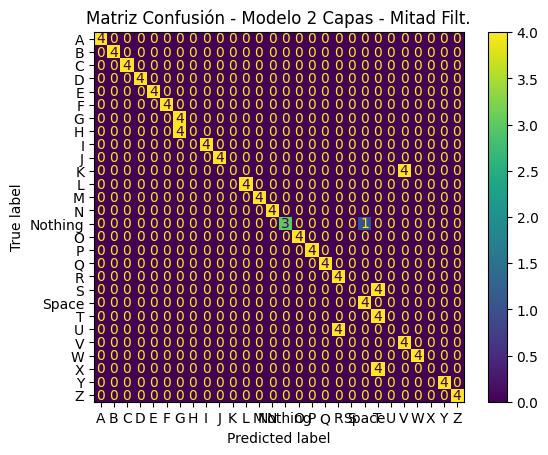

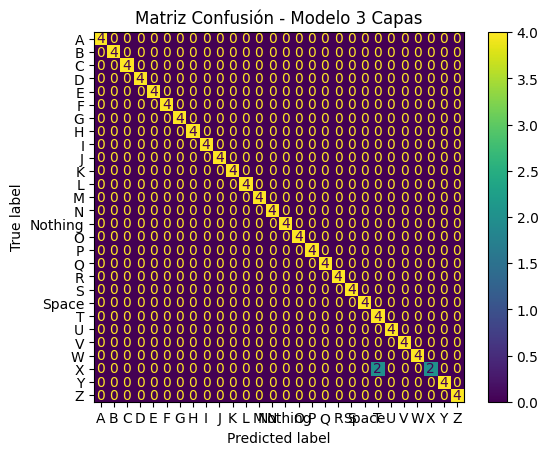

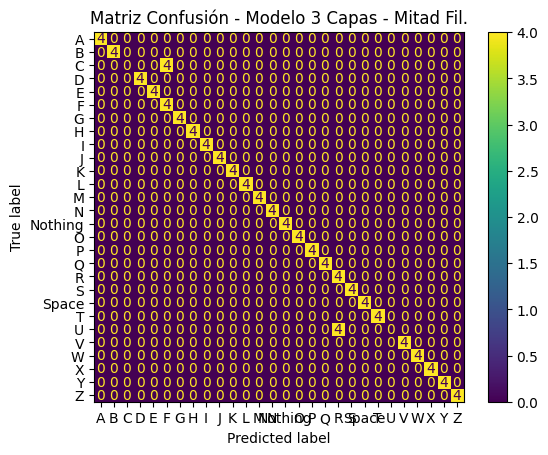

In [ ]:
#En esta parte se obtiene la matriz de confusión de cada uno de los 6 modelos
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Data_Prueba.classes, y_pred,
                          labels = list(Data_Prueba.class_indices.values())),
                       display_labels = list(Data_Prueba.class_indices.keys())).plot()
plt.title('Matriz Confusión - Modelo 1 Capa')

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Data_Prueba.classes, y_pred1,
                          labels = list(Data_Prueba.class_indices.values())),
                       display_labels = list(Data_Prueba.class_indices.keys())).plot()
plt.title('Matriz Confusión - Modelo 1 Capa - Mitad Filt.')

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Data_Prueba.classes, y_pred2,
                          labels = list(Data_Prueba.class_indices.values())),
                       display_labels = list(Data_Prueba.class_indices.keys())).plot()
plt.title('Matriz Confusión - Modelo 2 Capas')

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Data_Prueba.classes, y_pred3,
                          labels = list(Data_Prueba.class_indices.values())),
                       display_labels = list(Data_Prueba.class_indices.keys())).plot()
plt.title('Matriz Confusión - Modelo 2 Capas - Mitad Filt.')

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Data_Prueba.classes, y_pred4,
                          labels = list(Data_Prueba.class_indices.values())),
                       display_labels = list(Data_Prueba.class_indices.keys())).plot()
plt.title('Matriz Confusión - Modelo 3 Capas')

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Data_Prueba.classes, y_pred5,
                          labels = list(Data_Prueba.class_indices.values())),
                       display_labels = list(Data_Prueba.class_indices.keys())).plot()
plt.title('Matriz Confusión - Modelo 3 Capas - Mitad Fil.')

*La impresión de Filtros Inicia desde esta sección:*

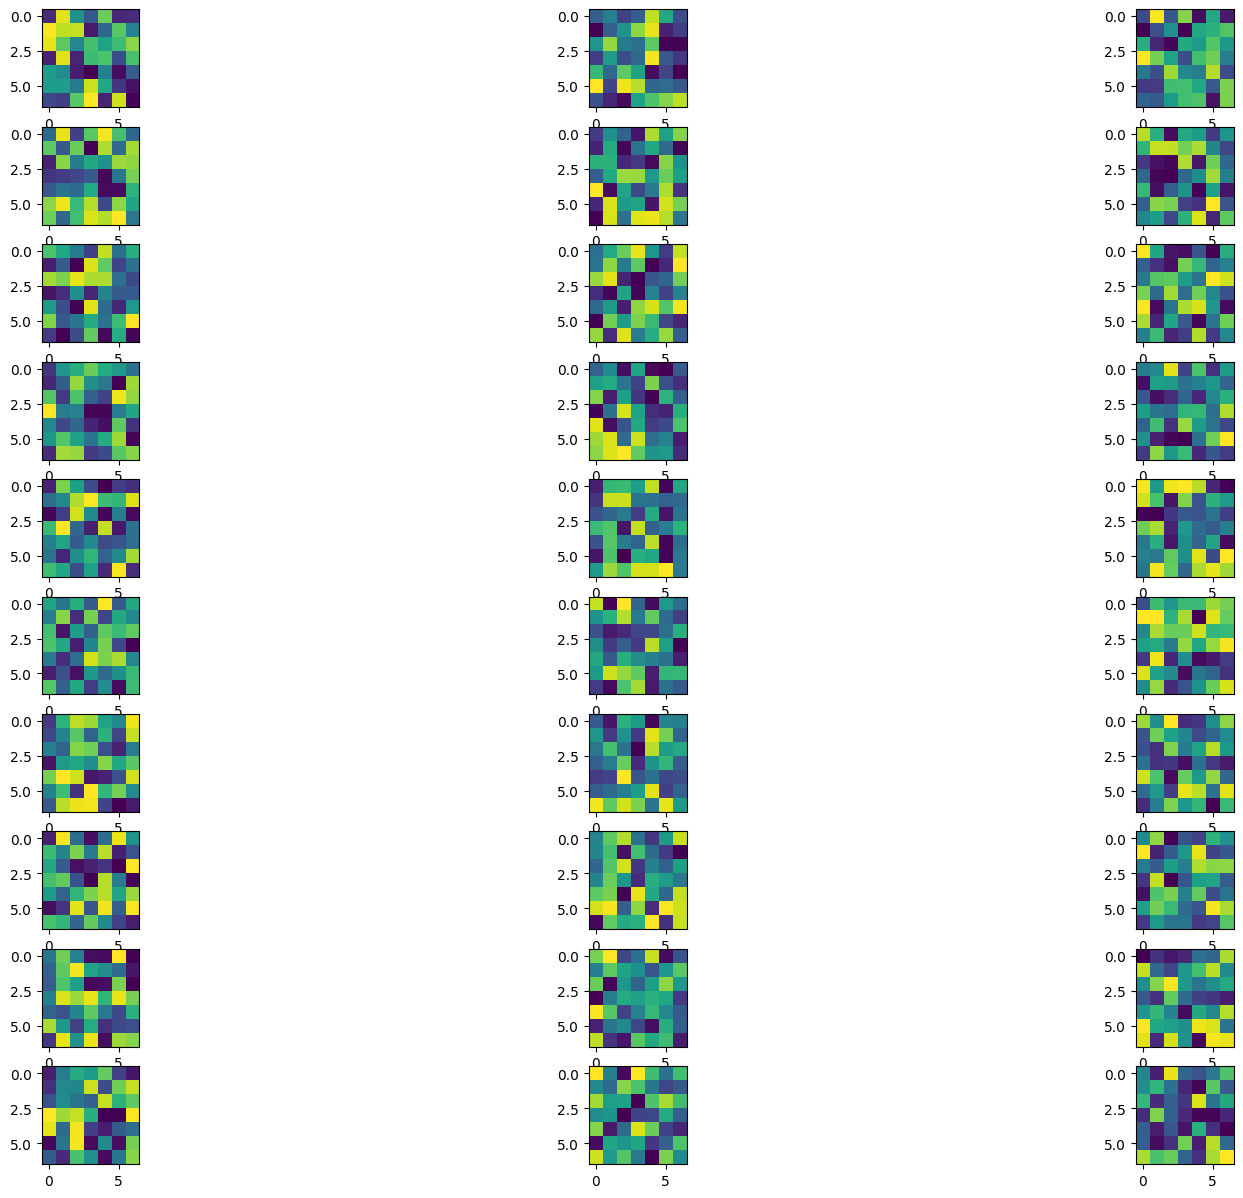

In [ ]:
print_filtros(InicialW0_Model)

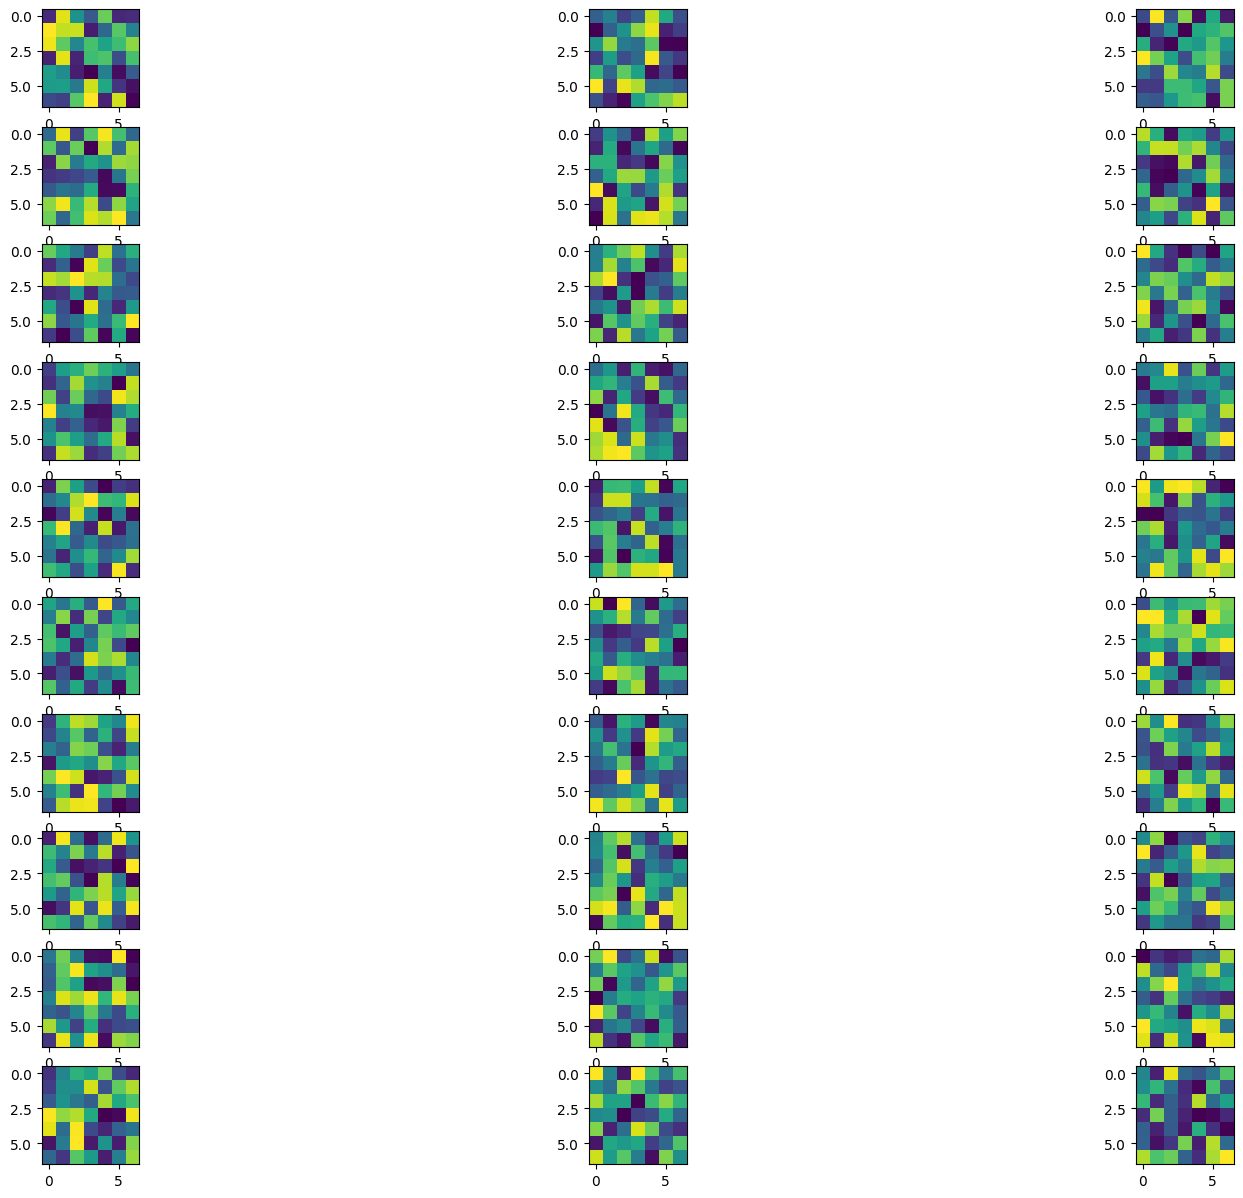

In [ ]:
print_filtros(W0_Model)

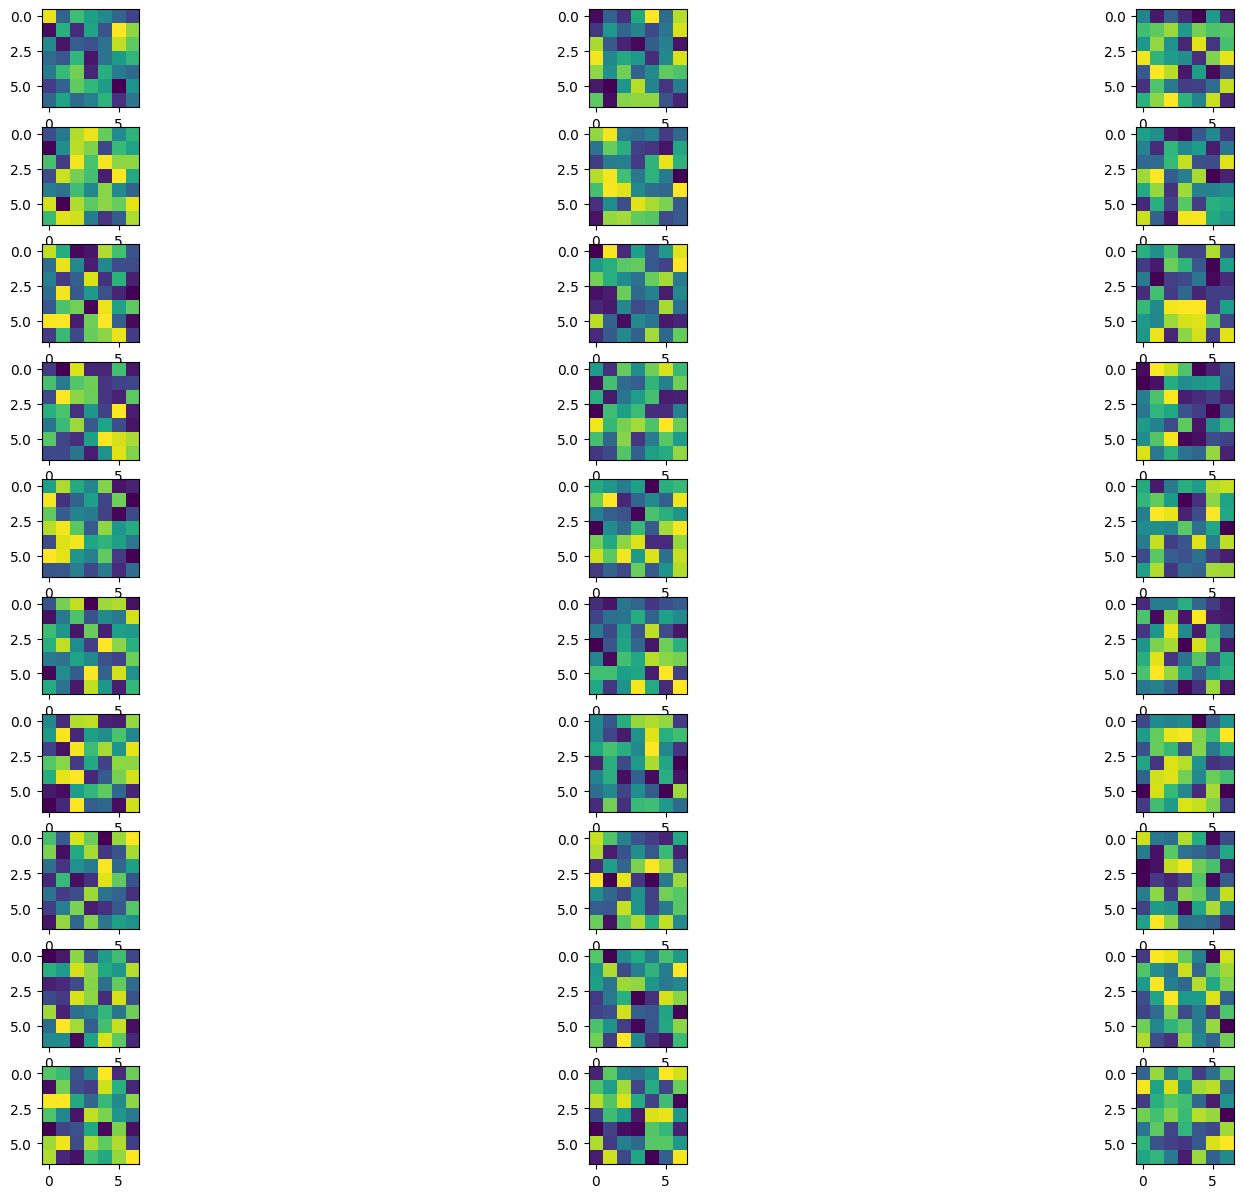

In [ ]:
print_filtros(InicialW0_Model1)

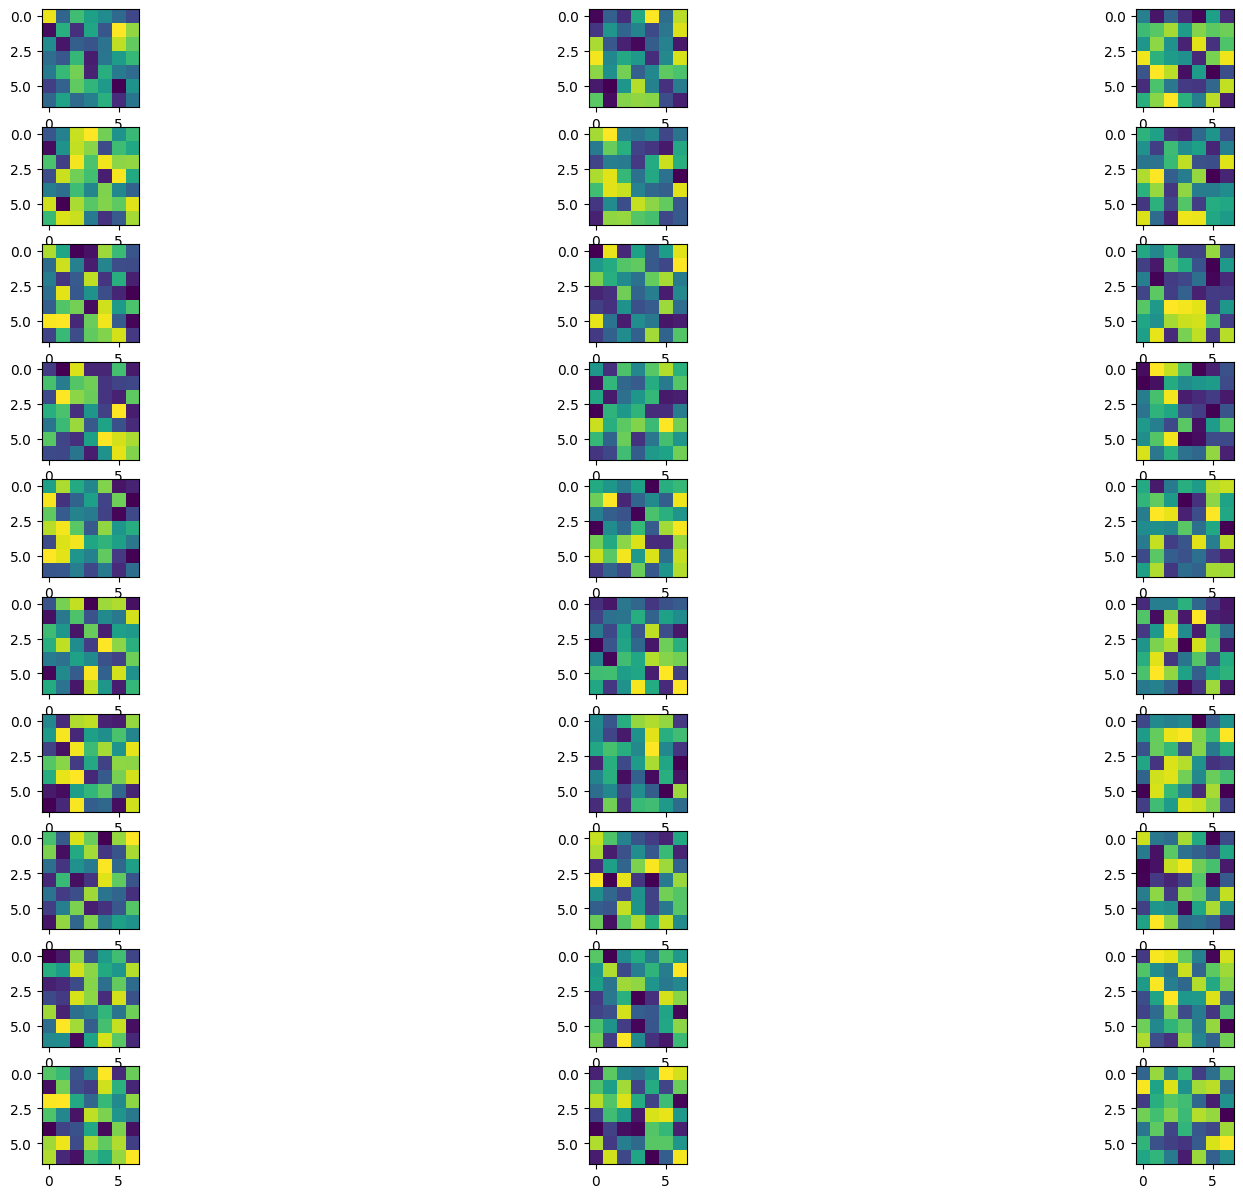

In [ ]:
print_filtros(W0_Model1)

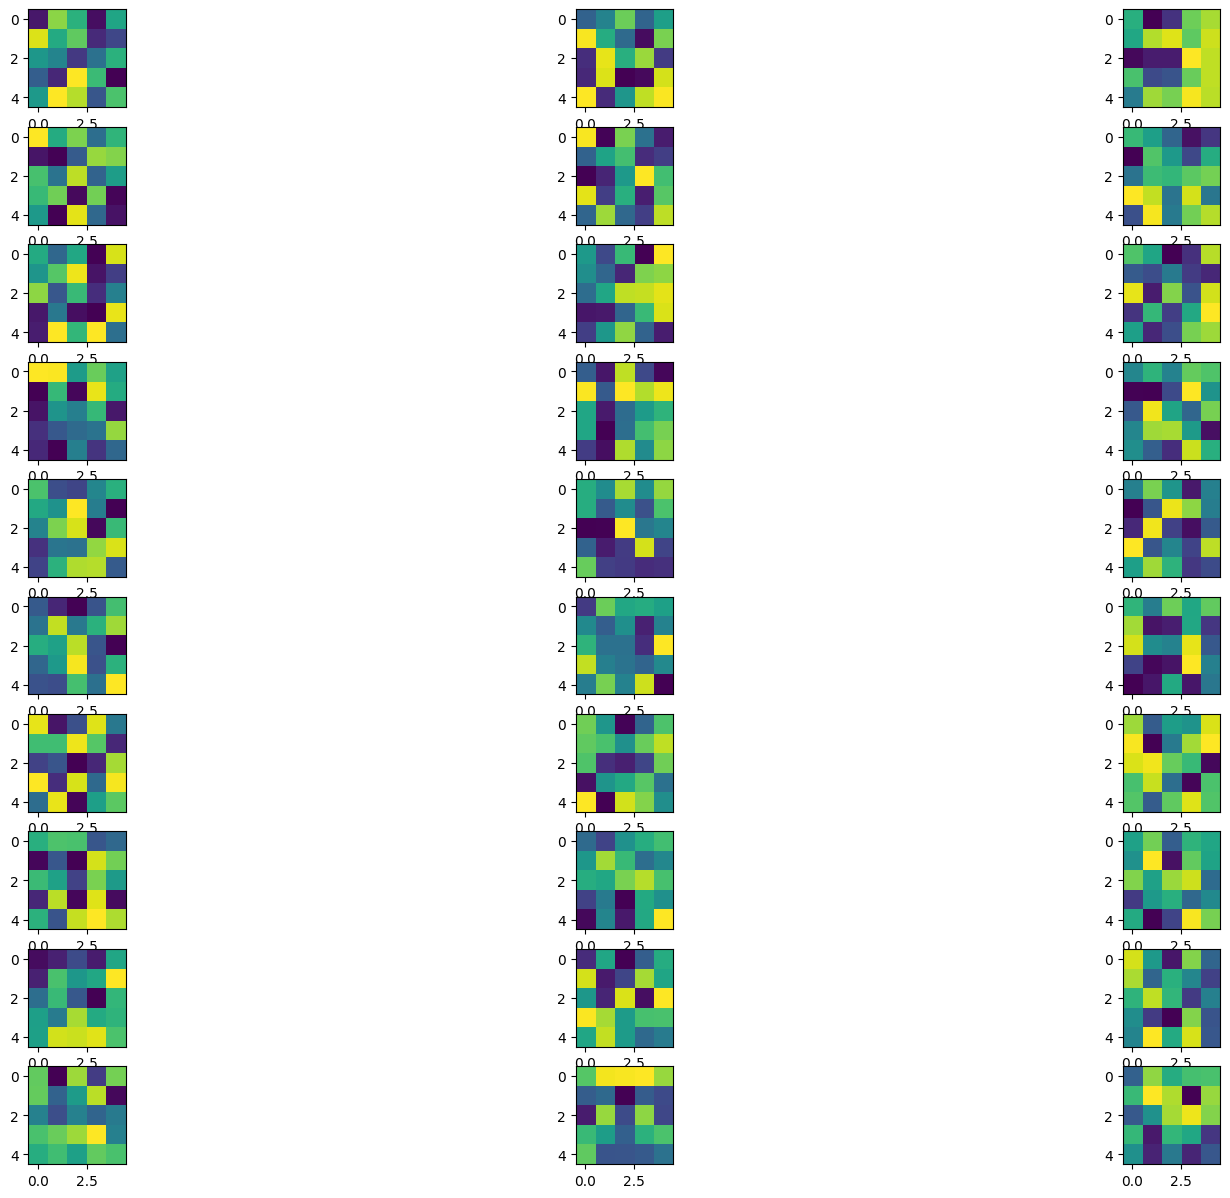

In [ ]:
print_filtros(InicialW0_Model2)

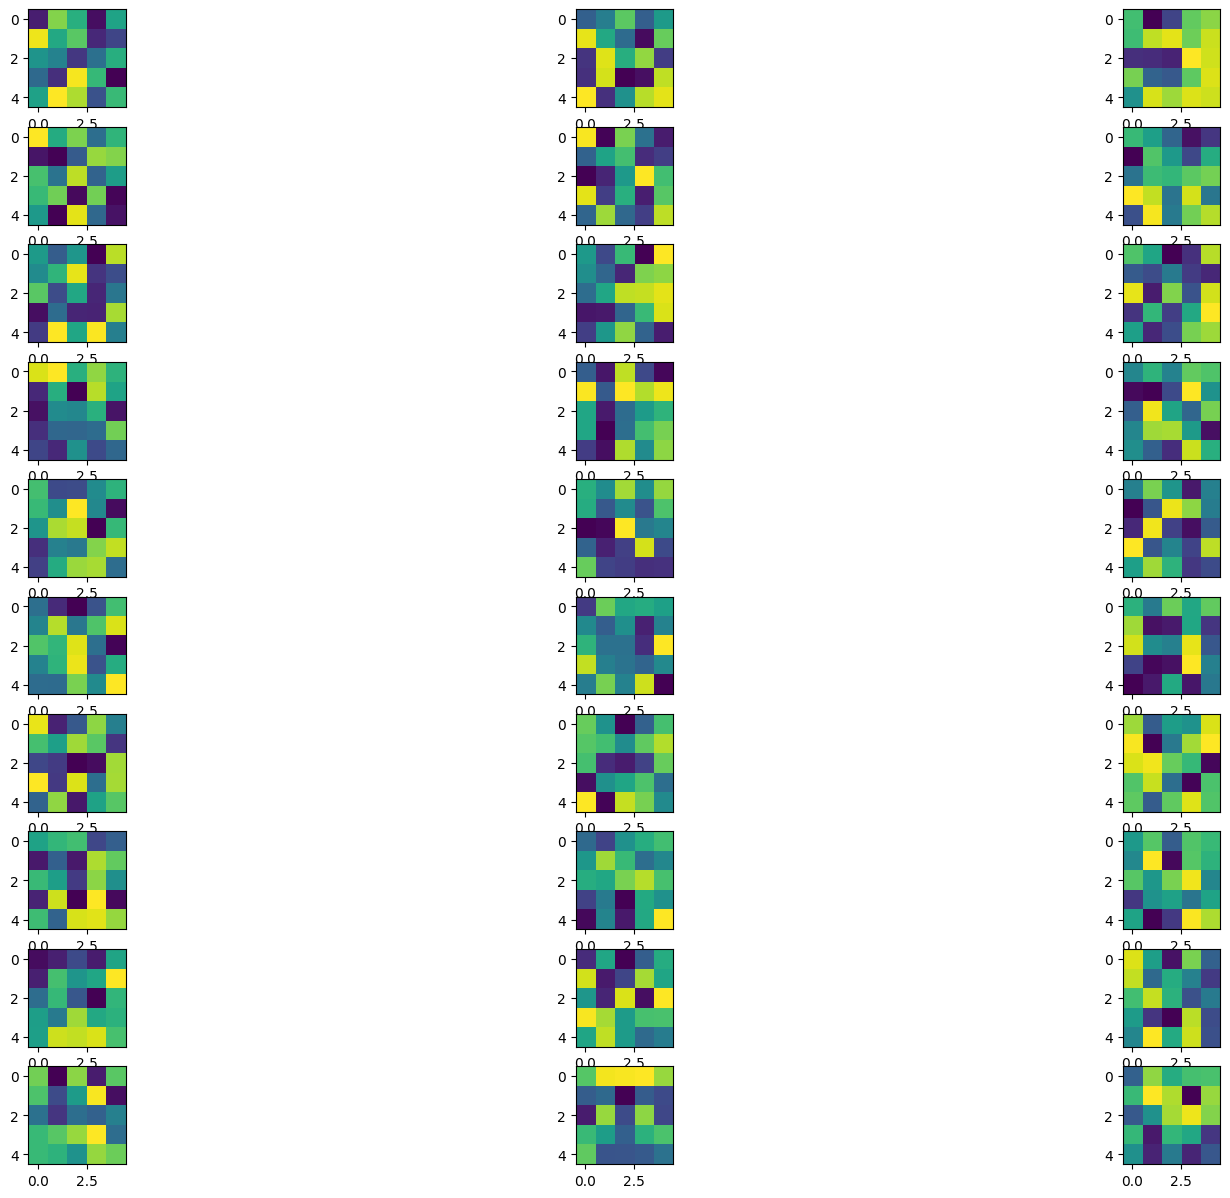

In [ ]:
print_filtros(W0_Model2)

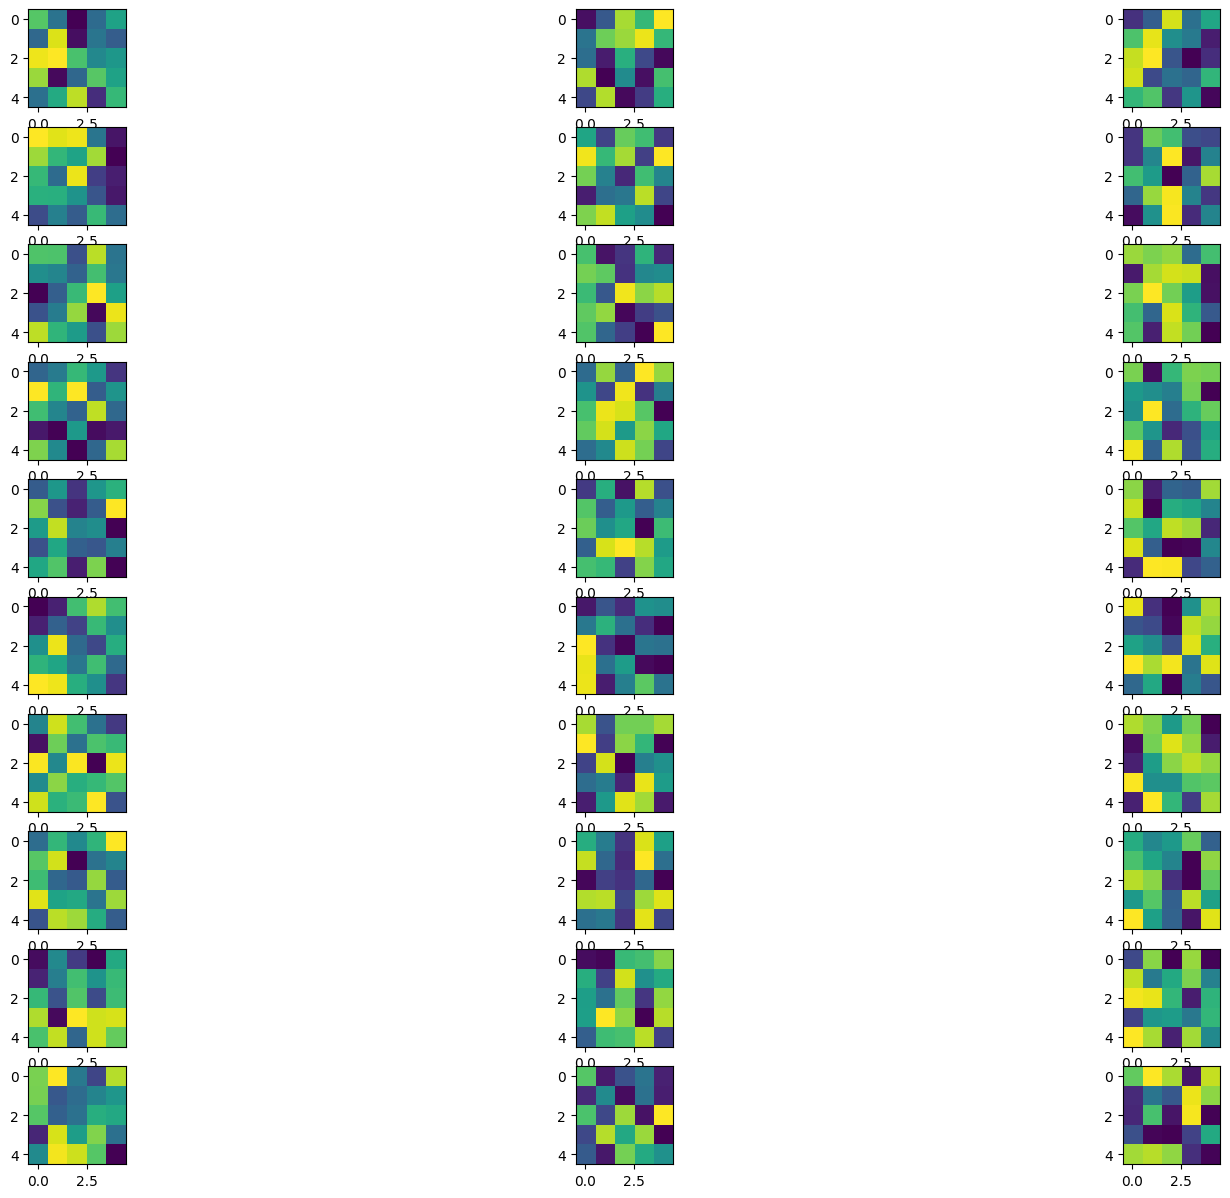

In [ ]:
print_filtros(InicialW0_Model3)

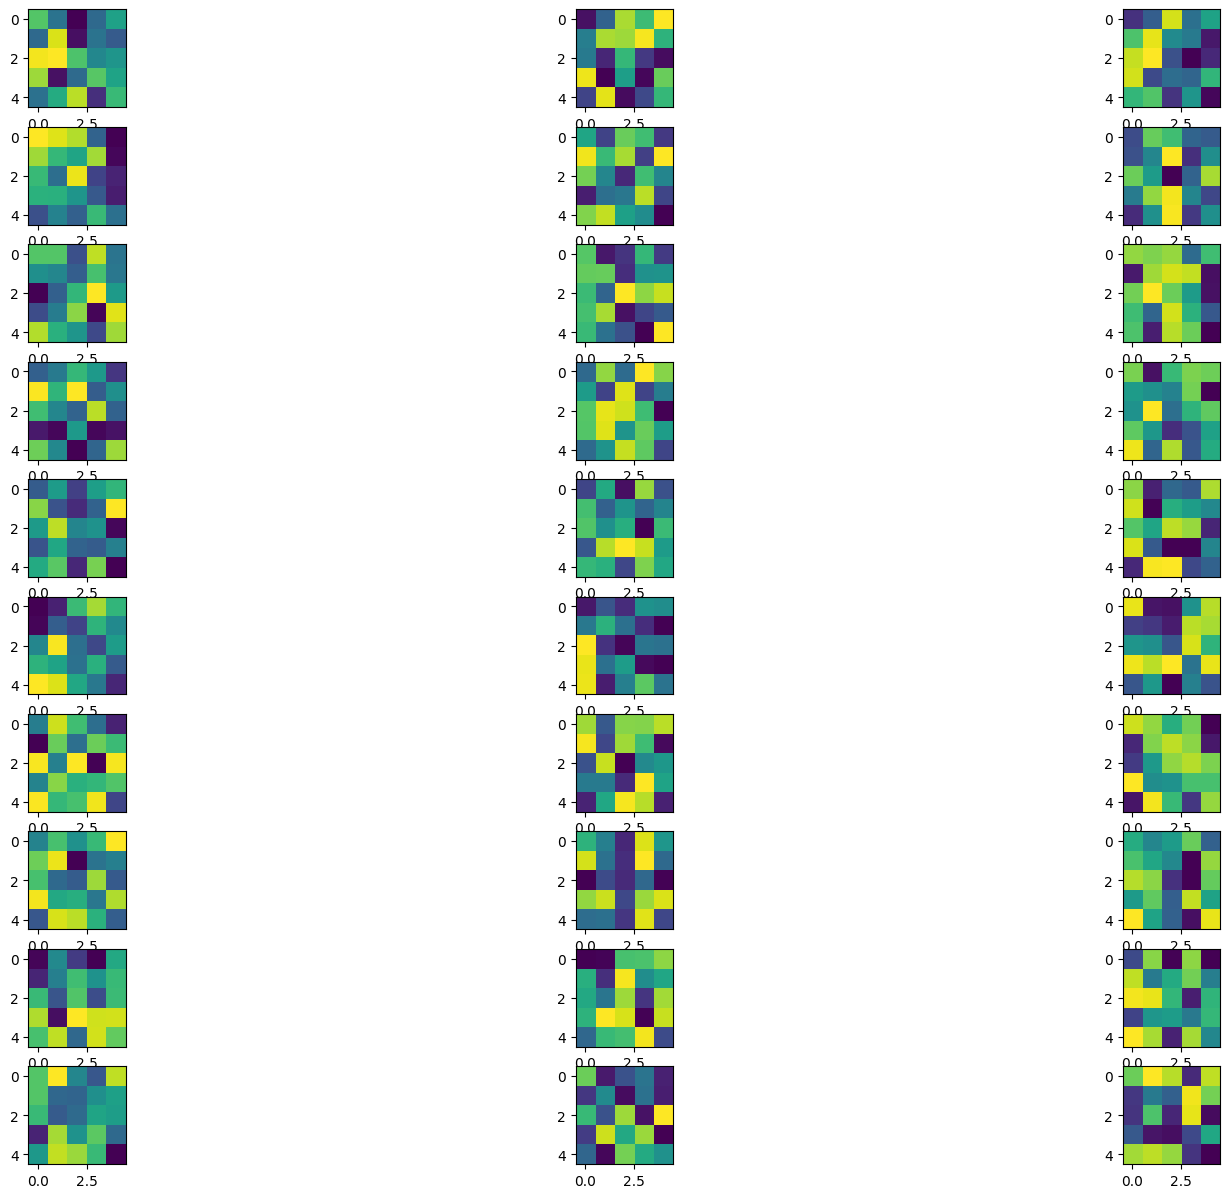

In [ ]:
print_filtros(W0_Model3)

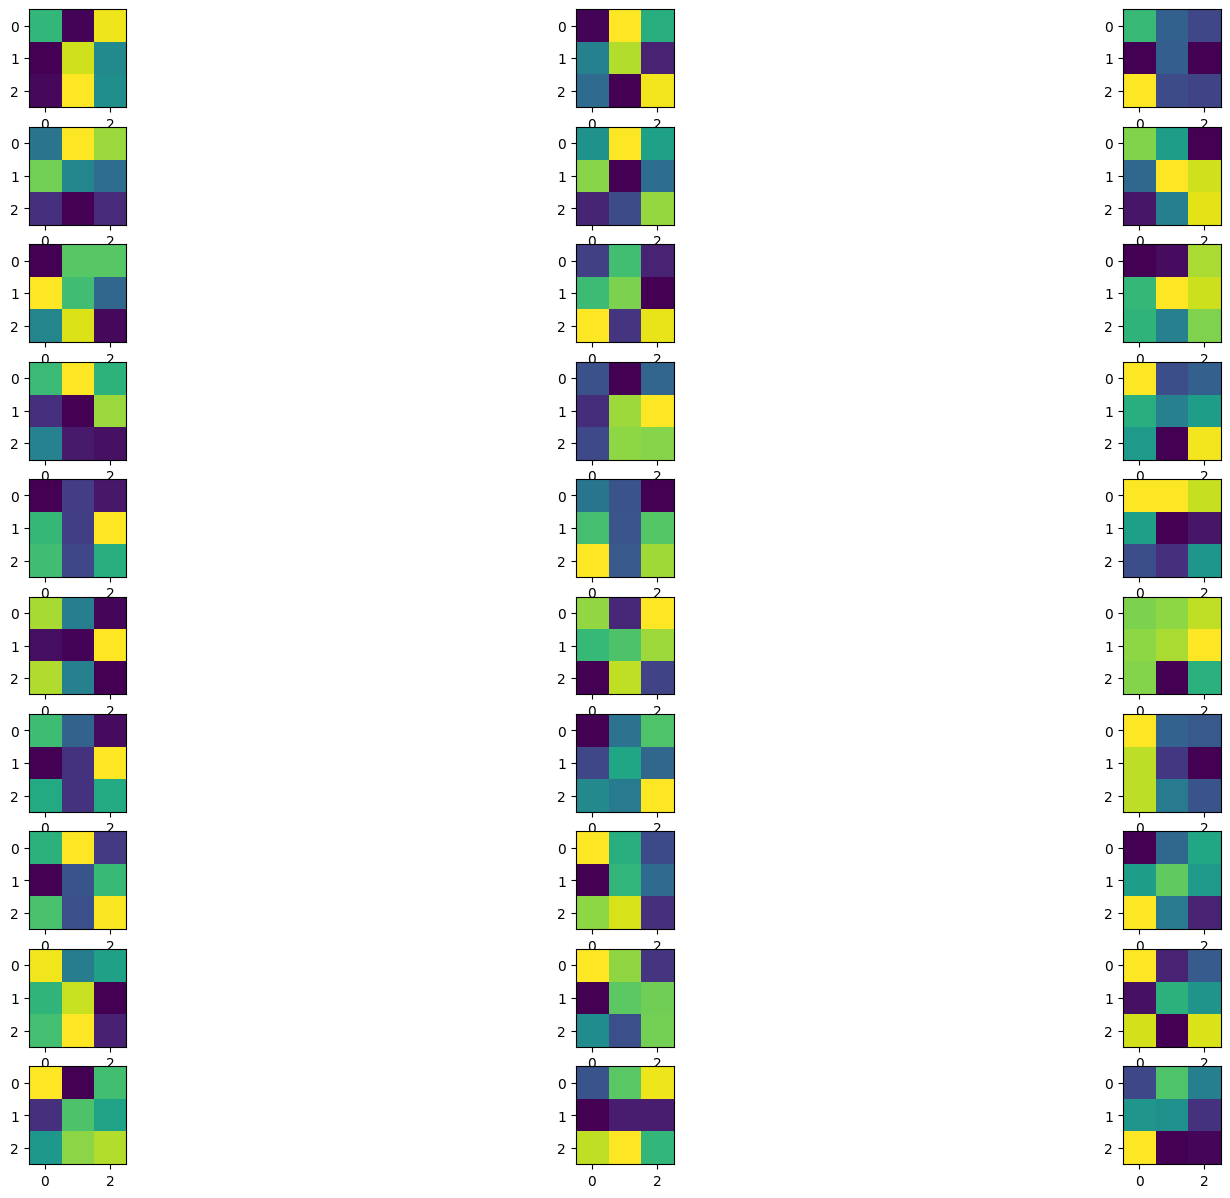

In [ ]:
print_filtros(InicialW0_Model4)

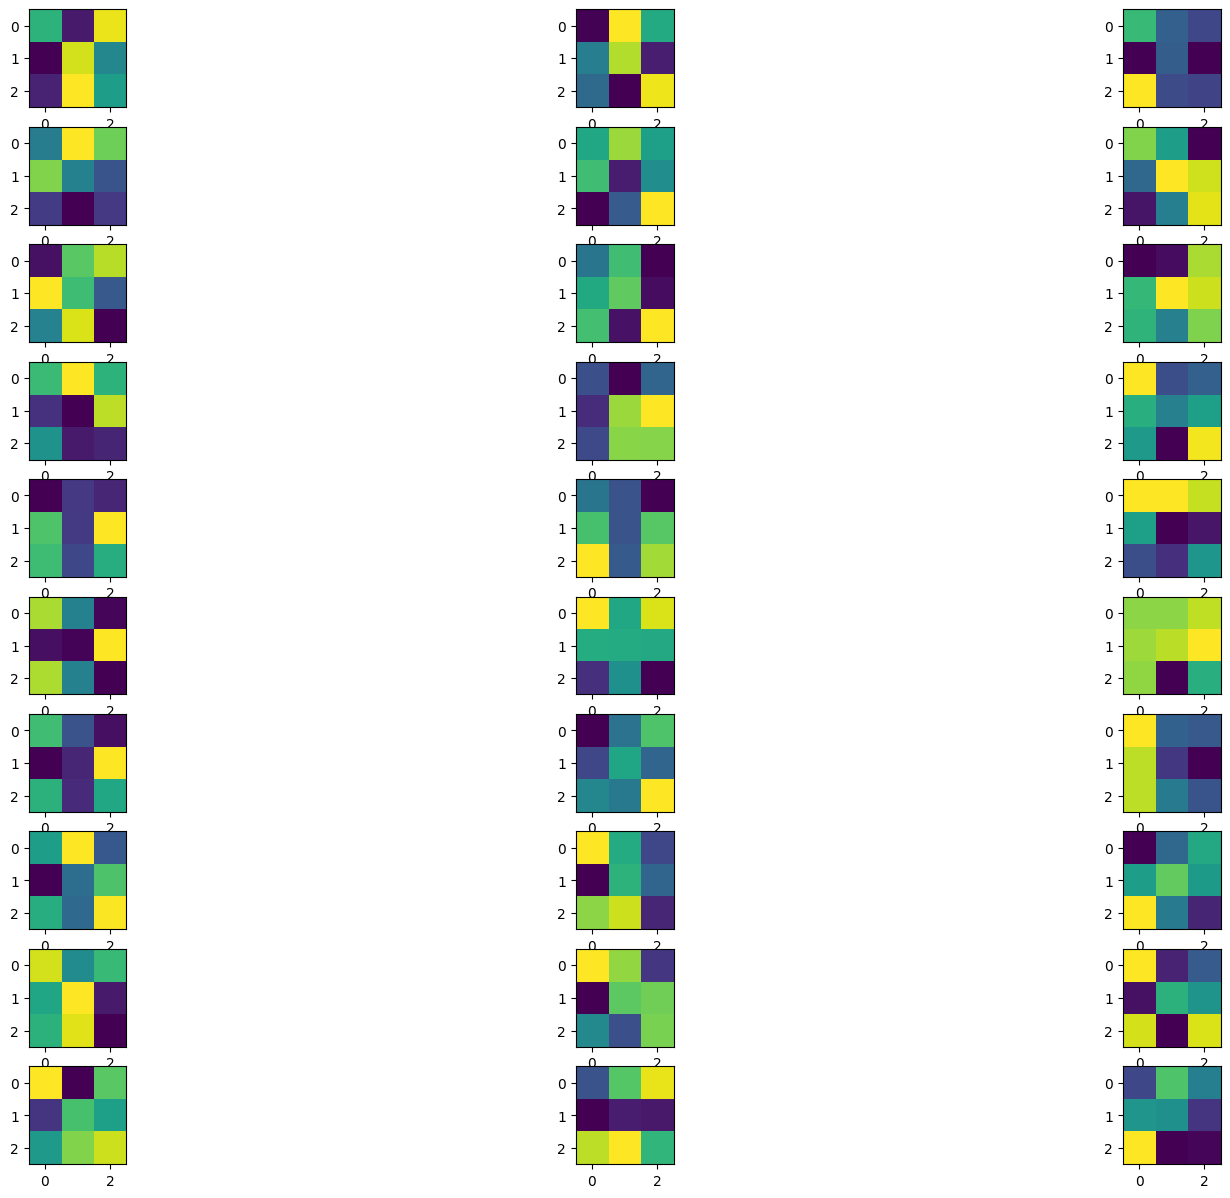

In [ ]:
print_filtros(W0_Model4)

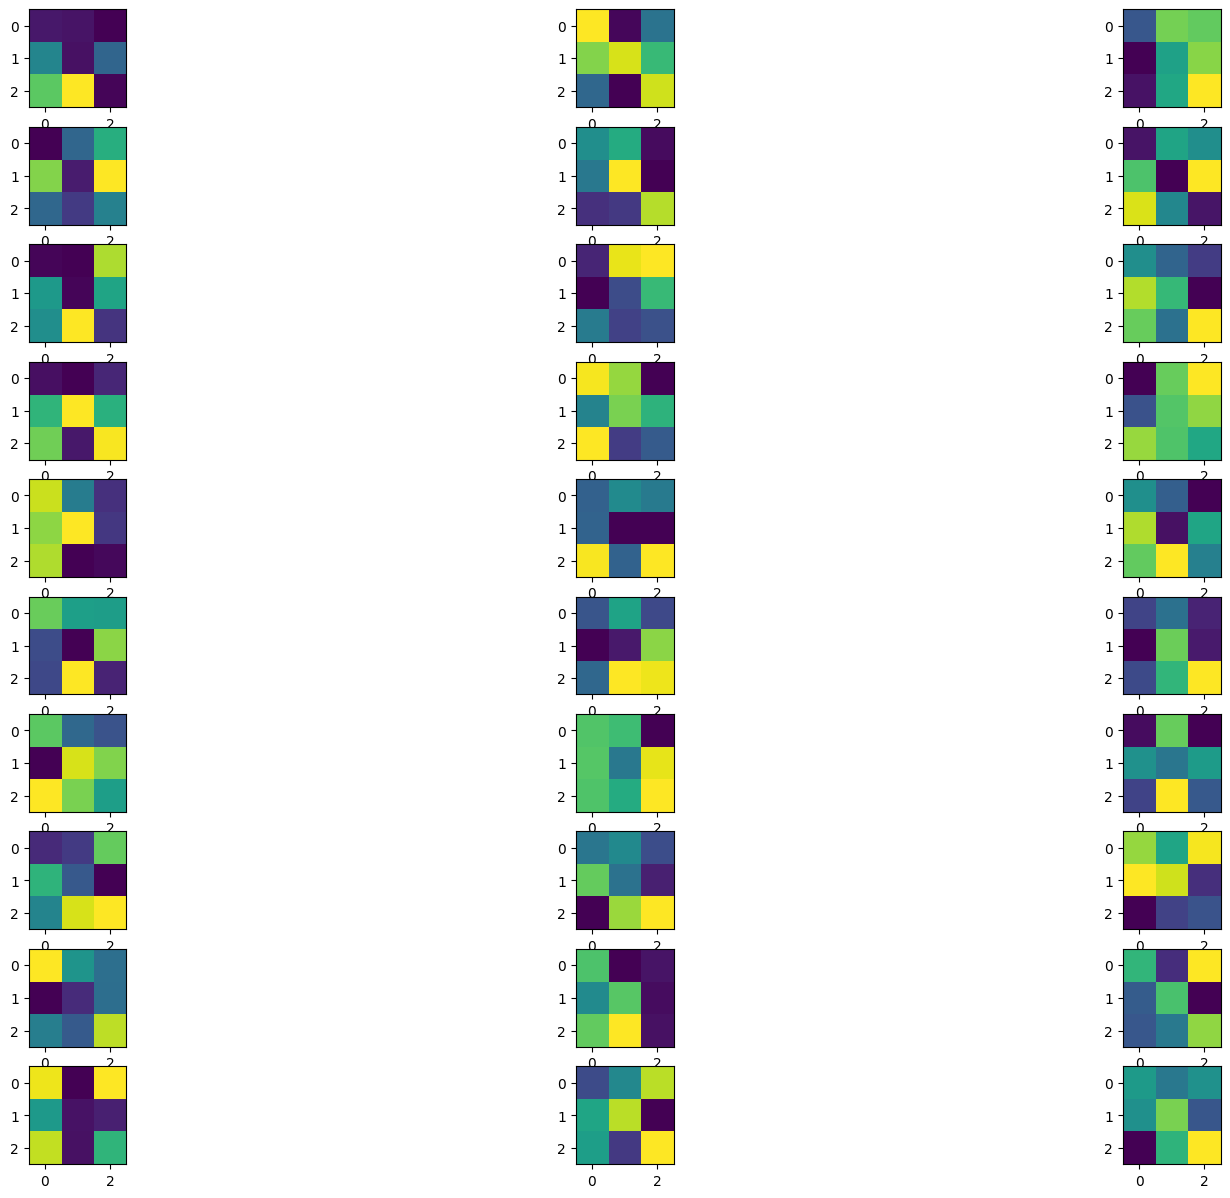

In [ ]:
print_filtros(InicialW0_Model5)

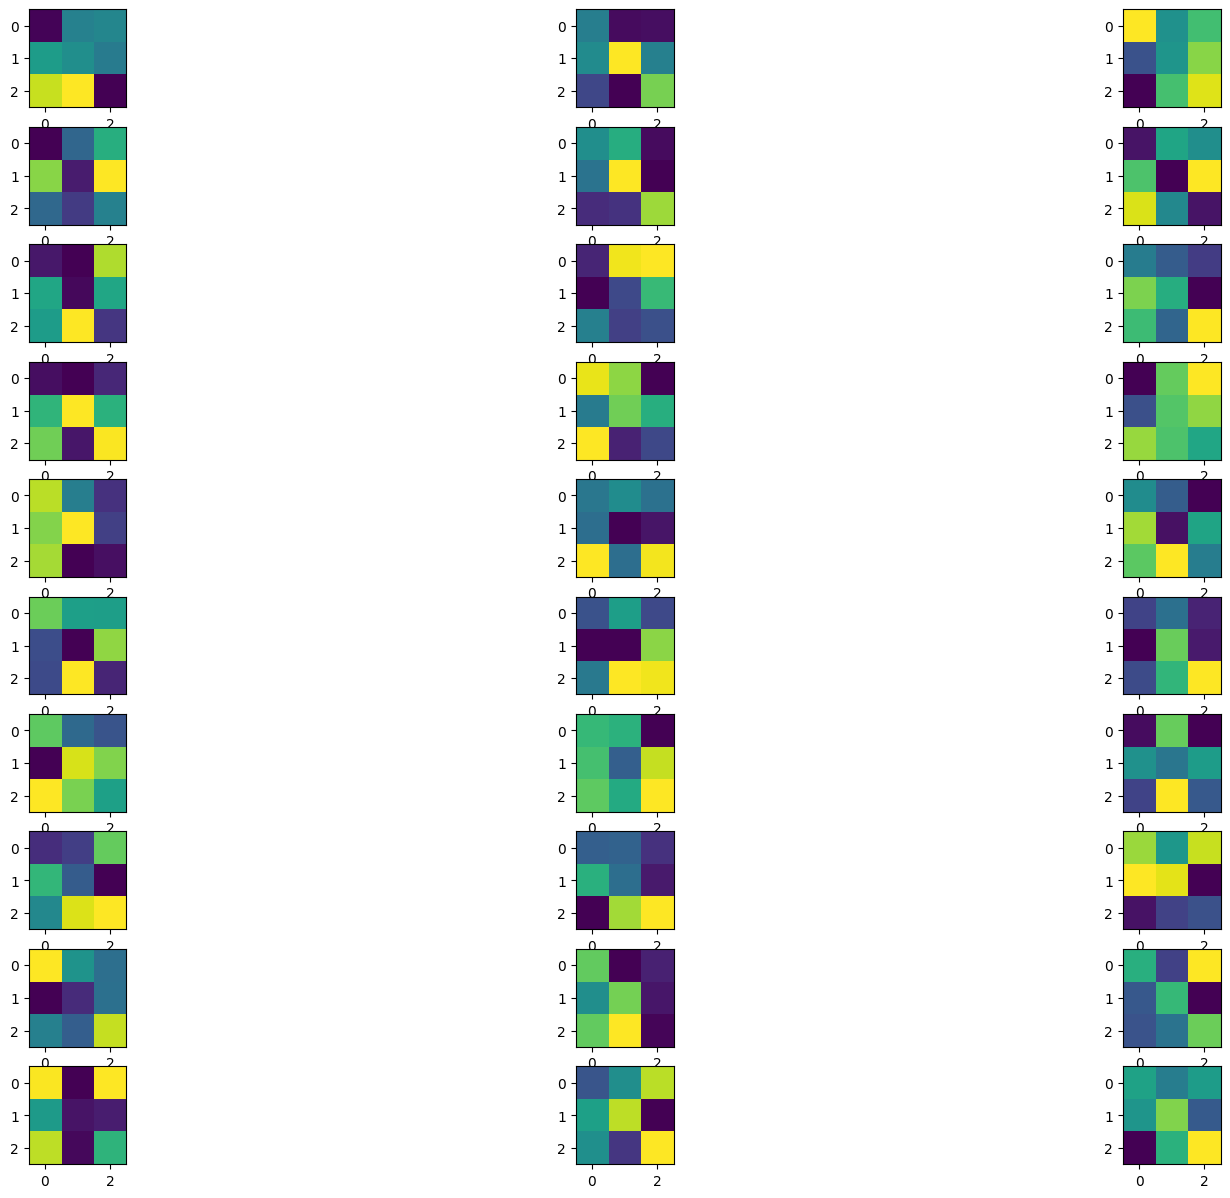

In [ ]:
print_filtros(W0_Model5)

***Finalmente, se Guarda el mejor modelo escogido:***

In [ ]:
#Se guarda el modelo con el mejor comportamiento
from tensorflow.keras.models import load_model
model4.save('/content/drive/MyDrive/Modelos/modeloCNNAlfaCap3BEST.hdf5')
model4.save_weights('/content/drive/MyDrive/Modelos/PesosCNNAlfaCap3BEST.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
